### Setup Notebook

In [109]:
from math import ceil
import os
import json
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd
from youtube_transcript_api import YouTubeTranscriptApi

from openai import OpenAI
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer

from tqdm.auto import tqdm

In [112]:
# config
VIDEO_ID = 'zjkBMFhNj_g'
LLM_MODEL = 'gemma2:2b'

DOCUMENT_COLS = ['uid', 'text', 'smry_text', 'clean_text', 'keywords']

VECTOR_MODEL = 'multi-qa-MiniLM-L6-cos-v1'
VECTOR_DIMS = 384

### Extract Transcript

In [4]:
srt = YouTubeTranscriptApi.get_transcript(VIDEO_ID)
df_srt = pd.DataFrame(srt)
df_srt.head(3)

,text,start,duration
0,hi everyone so recently I gave a,0.16,4.080
1,30-minute talk on large language models,2.28,4.119
2,just kind of like an intro talk um,4.24,4.240


In [5]:
def parse_transcript(df):
    out_text =""
    for _, row in df.iterrows():
        out_text += " " + row['text']
    return out_text

In [6]:
yt_transcribed = parse_transcript(df_srt)

In [7]:
len(yt_transcribed), len(yt_transcribed.split()), yt_transcribed[:200]

(64353,
 12151,
 ' hi everyone so recently I gave a 30-minute talk on large language models just kind of like an intro talk um unfortunately that talk was not recorded but a lot of people came to me after the talk and ')

### Create Input Blocks | Chunking

In [8]:
def create_blocks(df, block_size=5, stride=1, max_duration=120):
    '''
    Use sliding window of size 'block_size' minutes with stride of 'stride' minutes to generate text blocks.
    Generated blocks wil be limited to 'max_blocks' and can be changed depending upon the processing power.
    Default parameters allow videos of upto 2hrs. to be included.
    '''
    max_blocks = ceil(((max_duration-block_size)/stride)+1)
    max_len = ceil(max(df['start'])/60)
    df_out = pd.DataFrame()

    print(f"INFO: initiated block creation of video transcript")
    print(f"INFO: video length {max_len} | block size {block_size} | stride {stride} | max blocks {max_blocks}")

    for i in range(max_blocks):
        start = i*stride
        stop = block_size + i*stride
        df_block = df[(df['start']>= 60*start) & (df['start']<= 60*stop)]
        if (i + 1) % 5 == 0 or i + 1 == max_blocks:
            print(f"INFO: generated block {i+1} | start {start} | stop {stop} | rows combined {df_block.shape[0]}")
            print(f"INFO: reached max blocks limit")
        transcribed = parse_transcript(df_block)
        df_block = pd.DataFrame({'Block':[i+1], 'text':[transcribed], 'start_time': [min(df_block['start'])]})
        df_out = pd.concat([df_out, df_block])
        if stop >= max_len:
            print(f"INFO: generated block {i+1} | start {start} | stop {stop} | rows combined {df_block.shape[0]}")
            print(f"INFO: reached end of video")
            break
    
    df_out.reset_index(drop=True, inplace=True)
    print(f"INFO: original data {df.shape} | block data {df_out.shape}")
    return df_out

In [9]:
df_srt_v2 = create_blocks(df_srt)

INFO: initiated block creation of video transcript
INFO: video length 60 | block size 5 | stride 1 | max blocks 116
INFO: generated block 5 | start 4 | stop 9 | rows combined 140
INFO: reached max blocks limit
INFO: generated block 10 | start 9 | stop 14 | rows combined 150
INFO: reached max blocks limit
INFO: generated block 15 | start 14 | stop 19 | rows combined 140
INFO: reached max blocks limit
INFO: generated block 20 | start 19 | stop 24 | rows combined 143
INFO: reached max blocks limit
INFO: generated block 25 | start 24 | stop 29 | rows combined 143
INFO: reached max blocks limit
INFO: generated block 30 | start 29 | stop 34 | rows combined 139
INFO: reached max blocks limit
INFO: generated block 35 | start 34 | stop 39 | rows combined 149
INFO: reached max blocks limit
INFO: generated block 40 | start 39 | stop 44 | rows combined 146
INFO: reached max blocks limit
INFO: generated block 45 | start 44 | stop 49 | rows combined 137
INFO: reached max blocks limit
INFO: generated

In [10]:
df_srt_v2['text_length'] = df_srt_v2['text'].apply(len)
df_srt_v2['word_count'] = df_srt_v2['text'].apply(lambda x : len(x.split()))
df_srt_v2.head(3)

,Block,text,start_time,text_length,word_count
0,1,hi everyone so recently I gave a 30-minute ta...,0.160,5356,1015
1,2,biggest one now many people like this model s...,60.039,5378,1021
2,3,this is a float 16 uh number as the data type...,121.240,5384,1025


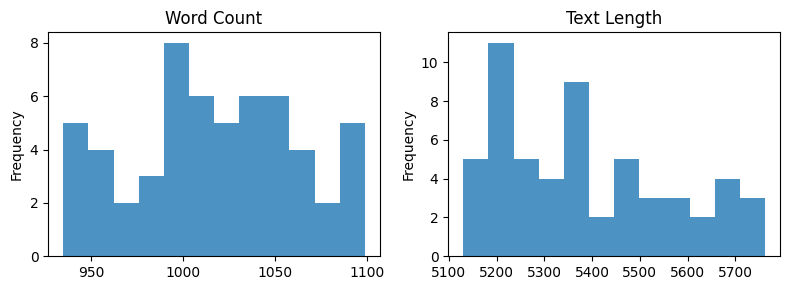

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

df_srt_v2['word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[0], title='Word Count')
df_srt_v2['text_length'].plot.hist(bins=12, alpha=0.8, ax=axes[1], title='Text Length')

plt.tight_layout()
plt.show()

### Generate Clean summary

In [12]:
client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama',
)

In [13]:
def llm(prompt, llm_model='gemma2:2b'):
    '''
    This function uses 'llm_model' to generate response for the provided input 'prompt' to llm.
    '''
    client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama',
    )
    
    response = client.chat.completions.create(
        model=llm_model,
        messages=[{"role": "user", "content": prompt}],
        # temperature=0,    # remove randomness for deterministic output but not using it as it makes summary clumsy with phrases like 'you stated correctly...', 'you explained it well...' etc.
        seed=72
    )

    return response.choices[0].message.content

In [14]:
def generate_smry(transcript, llm_model='gemma2:2b'):
    '''
    This function takes in a 'transcript' text and generates summarized text using 'llm_model' specified.
    '''
    smrize_prompt = """As a professional editor, your task is to convert the provided YouTube transcript into a concise, well-structured summary. Follow all of below steps:
        Steps:
        - Clean the text for spelling and grammatical correctness.
        - Remove filler words such as 'uhm', 'mhm', and similar phrases.
        - Retain as many original phrases as possible for authenticity.
        - Generate a summary text that contains all the information from input TRANSCRIPT and don't use words like 'you' and 'I' in the generated summary.
        - The summary should be organized into clearly labeled sections and subsections where applicable.
        - Ensure that all key information from the input TRANSCRIPT is included in the summary.
        - Don't add any new information, don't express your opinions about the speaker and don't suggest any follow up query.
        - Do not praise the speaker or me. Just provide the summary as per above directions.
        
        TRANSCRIPT: {INPUT_TRANSCRIPT}"""

    prompt = smrize_prompt.format(INPUT_TRANSCRIPT = transcript)

    return llm(prompt, llm_model)

In [ ]:
# llm test
response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[{"role": "user", "content": "What is dark matter? Answer in less than 50 words."}],
        seed=72
    )
print(response.choices[0].message.content)

In [ ]:
# original text
sample_text = df_srt_v2['text'][0]
print(sample_text)

In [ ]:
# summarised text
sample_smry = generate_smry(sample_text, llm_model=LLM_MODEL)
print(sample_smry)

In [ ]:
len(sample_smry), len(sample_smry.split())

In [15]:
def generate_smry_file(df_in, text_col='text', llm_model='gemma2:2b'):
    '''
    Iterates through each row and generates summary column content for the text in 'text_col'.
    '''
    df = df_in.copy()
    print(f"INFO: initiated summary generation")
    print(f"INFO: total text blocks {df.shape[0]}")
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating Summaries"):
        smry_text = generate_smry(row[text_col], llm_model)
        df.loc[index, 'smry_text'] = smry_text
    
    print(f"INFO: summary generation finished")
    return df

In [16]:
df_blocksmry = generate_smry_file(df_srt_v2, llm_model=LLM_MODEL)

INFO: initiated summary generation
INFO: total text blocks 56


Generating Summaries:   0%|          | 0/56 [00:00<?, ?it/s]

INFO: summary generation finished


In [17]:
# check generated summary
print(df_blocksmry.loc[6, 'smry_text'])

### Neural Network Text Generation: Key Takeaways
This text describes how neural networks work to predict the next word in a sequence.  The core principle is simple: given a series of words, a network attempts to identify the most likely succeeding word. 

**Understanding the Network:**

- Training data influences its behavior; a model learns from vast amounts of internet documents during training.
 - The "lossy compression" arises from predicting text.  Neural networks aim for accurate predictions, which compresses textual information using these learned relationships. 
- In essence, the network is like an advanced digital word-sumer that utilizes language patterns to predict, potentially generating text resembling online documents.

**Example: Ruth Handler Model:**

A simple example illustrates this process by showcasing how a neural network trained on Wikipedia pages can  predict following words and generate creative outcomes based on these learned connections between topics (in the

In [18]:
df_blocksmry['smry_text_length'] = df_blocksmry['smry_text'].apply(len)
df_blocksmry['smry_word_count'] = df_blocksmry['smry_text'].apply(lambda x : len(x.split()))
df_blocksmry['uid'] = df_blocksmry.apply(lambda x: VIDEO_ID + '__B' + str(x['Block']) + '__S' + str(x['start_time']), axis=1)

df_blocksmry.head(3)

,Block,text,start_time,text_length,word_count,smry_text,smry_text_length,smry_word_count,uid
0,1,hi everyone so recently I gave a 30-minute ta...,0.160,5356,1015,Large Language Models Explained\n\n**Overview:...,2344,363,zjkBMFhNj_g__B1__S0.16
1,2,biggest one now many people like this model s...,60.039,5378,1021,**Llama 270b Model Unveiled:**\n\nThis transcr...,2054,308,zjkBMFhNj_g__B2__S60.039
2,3,this is a float 16 uh number as the data type...,121.240,5384,1025,### Summary\n\nThis transcript describes a sys...,1958,282,zjkBMFhNj_g__B3__S121.24


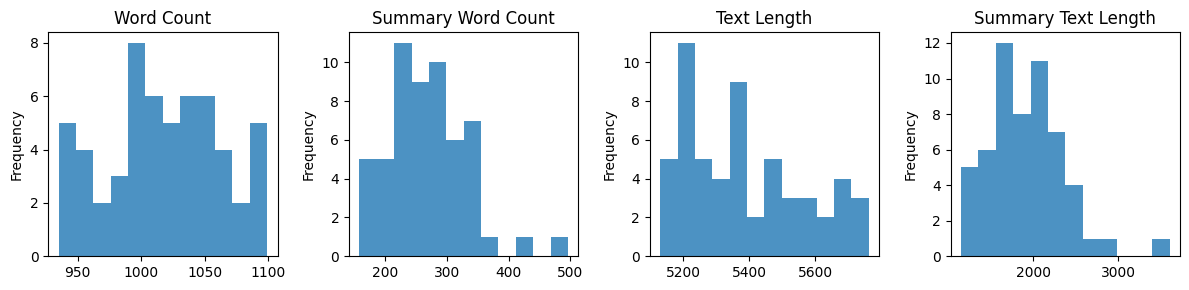

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

df_blocksmry['word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[0], title='Word Count')
df_blocksmry['smry_word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[1], title='Summary Word Count')
df_blocksmry['text_length'].plot.hist(bins=12, alpha=0.8, ax=axes[2], title='Text Length')
df_blocksmry['smry_text_length'].plot.hist(bins=12, alpha=0.8, ax=axes[3], title='Summary Text Length')

plt.tight_layout()
plt.show()

In [20]:
def export_df_to_json(df, filename):
    '''
    df : the dataframe that needs to be dumped as json
    filename : string path and name of the destination json file
    '''
    df_json = df.to_dict(orient="records")
    with open(filename, 'wt') as f_out:
        json.dump(df_json, f_out, indent=2)



def load_jsonfile(filename):
    '''
    filename : filepath and filename(.json file) as a single string
    This function can be used to read any json file
    '''
    with open(filename, 'rt') as f:
        data_json = json.load(f)
    return data_json

In [21]:
# create the directory if it doesn't exist
os.makedirs("../data/summary_transcripts/", exist_ok=True)

export_df_to_json(df_blocksmry, "../data/summary_transcripts/tscribe1_vid_"+VIDEO_ID+".json")

### Generate Clean Text
This is just supposed to be a cleaned transcript, not a summary. It did not work reliably but seems passable to be used as an extra column for searching query responses so exporting a json with clean text to use later to generate a better responses.

In [22]:
temp_jfile = load_jsonfile("../data/summary_transcripts/tscribe1_vid_"+VIDEO_ID+".json")
df_blocksmry = pd.DataFrame(temp_jfile)

In [23]:
def generate_cleantxt(transcript, llm_model='gemma2:2b'):
    '''
    This function takes in a 'transcript' text and generates summarized text using 'llm_model' specified.
    '''
    cleantxt_prompt = """As a proof reader, your task is to clean the provided YouTube transcript without omitting any information from the original text.
        The generated clean output should be grammatically correct, should not have any spelling mistakes.
        It should not have filler words such as 'uhm', 'mhm', and similar phrases that can be heard in audio but does not make any sense in written transcript.
        Retain all the original phrases for authenticity.
        Don't add any new information, don't express your opinions about the speaker and don't suggest any follow up query.
        Do not praise the speaker or me. Just provide the cleaned text as per above directions.
        
        TRANSCRIPT: {INPUT_TRANSCRIPT}"""

    prompt = cleantxt_prompt.format(INPUT_TRANSCRIPT = transcript)

    response = client.chat.completions.create(
        model=llm_model,
        messages=[{"role": "user", "content": prompt}],
        # temperature=0,    # remove randomness for deterministic output but not using it as it makes summary clumsy with phrases like 'you stated correctly...', 'you explained it well...' etc.
        seed=72
    )

    return response.choices[0].message.content

In [ ]:
# original text
sample_text = df_srt_v2['text'][0]
print(len(sample_text.split()), sample_text)

In [ ]:
# cleaned text
sample_smry = generate_cleantxt(sample_text, llm_model='phi3')
print(len(sample_smry.split()), sample_smry)

In [24]:
def generate_cleantxt_file(df_in, text_col='text', llm_model='gemma2:2b'):
    '''
    Iterates through each row and generates cleaned text column for the text in 'text_col'.
    '''
    df = df_in.copy()
    print(f"INFO: initiated text cleaning")
    print(f"INFO: total text blocks {df.shape[0]}")
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Cleaning Texts"):
        clean_text = generate_cleantxt(row[text_col], llm_model)
        df.loc[index, 'clean_text'] = clean_text
    
    print(f"INFO: text cleaning finished")
    return df

In [25]:
df_blocksmry_v2 = generate_cleantxt_file(df_blocksmry, llm_model=LLM_MODEL)

INFO: initiated text cleaning
INFO: total text blocks 56


Cleaning Texts:   0%|          | 0/56 [00:00<?, ?it/s]

INFO: text cleaning finished


In [26]:
df_blocksmry_v2['clean_text_length'] = df_blocksmry_v2['clean_text'].apply(len)
df_blocksmry_v2['clean_word_count'] = df_blocksmry_v2['clean_text'].apply(lambda x : len(x.split()))

df_blocksmry_v2.head(2)

,Block,text,start_time,text_length,word_count,smry_text,smry_text_length,smry_word_count,uid,clean_text,clean_text_length,clean_word_count
0,1,hi everyone so recently I gave a 30-minute ta...,0.160,5356,1015,Large Language Models Explained\n\n**Overview:...,2344,363,zjkBMFhNj_g__B1__S0.16,"Hey everyone, recently I gave a 30-minute talk...",4199,741
1,2,biggest one now many people like this model s...,60.039,5378,1021,**Llama 270b Model Unveiled:**\n\nThis transcr...,2054,308,zjkBMFhNj_g__B2__S60.039,Largest open-weights model. Its strength in po...,3122,512


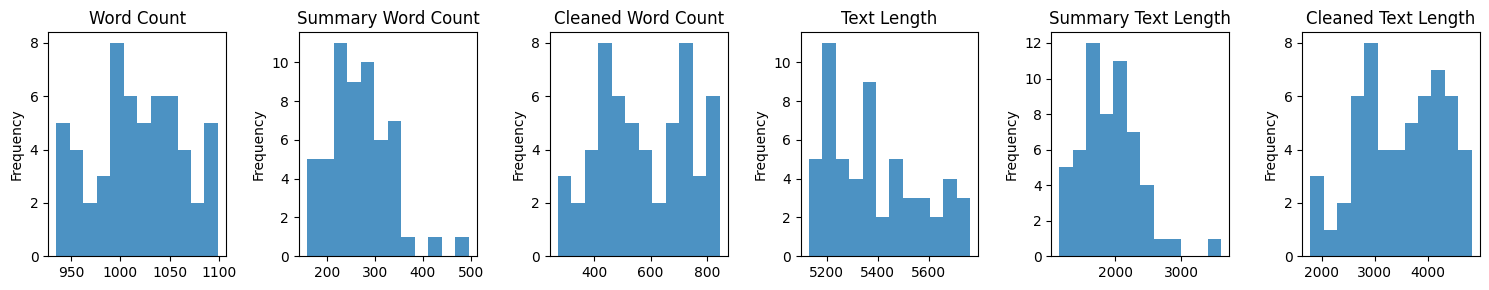

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))

df_blocksmry_v2['word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[0], title='Word Count')
df_blocksmry_v2['smry_word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[1], title='Summary Word Count')
df_blocksmry_v2['clean_word_count'].plot.hist(bins=12, alpha=0.8, ax=axes[2], title='Cleaned Word Count')
df_blocksmry_v2['text_length'].plot.hist(bins=12, alpha=0.8, ax=axes[3], title='Text Length')
df_blocksmry_v2['smry_text_length'].plot.hist(bins=12, alpha=0.8, ax=axes[4], title='Summary Text Length')
df_blocksmry_v2['clean_text_length'].plot.hist(bins=12, alpha=0.8, ax=axes[5], title='Cleaned Text Length')

plt.tight_layout()
plt.show()

In [28]:
export_df_to_json(df_blocksmry_v2, "../data/summary_transcripts/tscribe2_vid_"+VIDEO_ID+".json")

### Generate Topics & Keywords

In [29]:
temp_jfile = load_jsonfile("../data/summary_transcripts/tscribe2_vid_"+VIDEO_ID+".json")
df_blocksmry_v2 = pd.DataFrame(temp_jfile)

In [63]:
def generate_keywords(transcript, llm_model='gemma2:2b'):
    '''
    This function takes in original/summary/cleaned 'transcript' text and generates a list of keywords and topics using 'llm_model' specified.
    '''
    keyword_prompt = """Analyze the following YouTube video TRANSCRIPT and generate a string with comma-separated 15 to 30 keywords and topics that have been discussed in the TRANSCRIPT.
        Use original phrases from TRANSCRIPT for authenticity.

        Generated Output: "keyword1, keyword2, keyword3, ...."
        
        TRANSCRIPT: {INPUT_TRANSCRIPT}"""

    prompt = keyword_prompt.format(INPUT_TRANSCRIPT = transcript)

    response = client.chat.completions.create(
        model=llm_model,
        messages=[{"role": "user", "content": prompt}],
        # temperature=0,    # remove randomness for deterministic output but not using it as it makes summary clumsy with phrases like 'you stated correctly...', 'you explained it well...' etc.
        seed=72
    )

    return response.choices[0].message.content

In [64]:
# original text
sample_text = df_blocksmry_v2['text'][6]
print(len(sample_text.split()), sample_text)

1035  and so it's kind of like a lossy compression you can think about it that way the one more thing to point out here is these numbers here are actually by today's standards in terms of state-of-the-art rookie numbers uh so if you want to think about state-of-the-art neural networks like say what you might use in chpt or Claude or Bard or something like that uh these numbers are off by factor of 10 or more so you would just go in then you just like start multiplying um by quite a bit more and that's why these training runs today are many tens or even potentially hundreds of millions of dollars very large clusters very large data sets and this process here is very involved to get those parameters once you have those parameters running the neural network is fairly computationally cheap okay so what is this neural network really doing right I mentioned that there are these parameters um this neural network basically is just trying to predict the next word in a sequence you can think abo

In [65]:
# keywords
sample_smry = generate_keywords(sample_text, llm_model=LLM_MODEL)
print(len(sample_smry.split(',')), sample_smry)

20 deep learning, neural networks, natural language processing, word prediction, compression, internet, training data, machine learning, state-of-the-art, next word prediction, language model, random web page, Wikipedia, Ruth Handler, AI, hallucinated text,  knowledge,  representation, lossy compression, textual generation 



In [66]:
def generate_kwrd_file(df_in, text_col='smry_text', llm_model='gemma2:2b'):
    '''
    Iterates through each row and generates keyword column content for the text in 'text_col'.
    '''
    df = df_in.copy()
    print(f"INFO: initiated keywords generation")
    print(f"INFO: total text blocks {df.shape[0]}")
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating Keywords"):
        keywords = generate_keywords(row[text_col], llm_model)
        df.loc[index, 'keywords'] = keywords
    
    print(f"INFO: keywords generation finished")
    return df

In [68]:
df_blocksmry_v3 = generate_kwrd_file(df_blocksmry_v2, text_col='text', llm_model=LLM_MODEL)

INFO: initiated keywords generation
INFO: total text blocks 56


Generating Keywords:   0%|          | 0/56 [00:00<?, ?it/s]

INFO: keywords generation finished


In [69]:
export_df_to_json(df_blocksmry_v3, "../data/summary_transcripts/tscribe3_vid_"+VIDEO_ID+".json")

In [72]:
export_df_to_json(df_blocksmry_v3[DOCUMENT_COLS], "../data/summary_transcripts/tscribe_vid_"+VIDEO_ID+".json")

### Embedding and Indexing using ElasticSearch (Text Based Retrieval)

In [73]:
documents = load_jsonfile("../data/summary_transcripts/tscribe_vid_"+VIDEO_ID+".json")

len(documents), documents[0]

(56,
 {'uid': 'zjkBMFhNj_g__B1__S0.16',
  'text': " hi everyone so recently I gave a 30-minute talk on large language models just kind of like an intro talk um unfortunately that talk was not recorded but a lot of people came to me after the talk and they told me that uh they really liked the talk so I would just I thought I would just re-record it and basically put it up on YouTube so here we go the busy person's intro to large language models director Scott okay so let's begin first of all what is a large language model really well a large language model is just two files right um there will be two files in this hypothetical directory so for example working with a specific example of the Llama 270b model this is a large language model released by meta Ai and this is basically the Llama series of language models the second iteration of it and this is the 70 billion parameter model of uh of this series so there's multiple models uh belonging to the Llama 2 Series uh 7 billion um 13 bil

In [74]:
es_client = Elasticsearch('http://localhost:9200')
es_client.info()

ObjectApiResponse({'name': '5f3f4789699f', 'cluster_name': 'docker-cluster', 'cluster_uuid': '3B5jGztWSgCoUl7IEiAi3g', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [77]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "uid": {"type": "text"},
            "text": {"type": "text"},
            "smry_text": {"type": "text"},
            "clean_text": {"type": "text"},
            "keywords": {"type": "text"}
        }
    }
}


index_name = "video-transcripts"

if es_client.indices.exists(index=index_name):
    es_client.indices.delete(index=index_name)
    print(f"INFO: index '{index_name}' deleted.")

es_client.indices.create(index=index_name, body=index_settings)
print(f"INFO: index '{index_name}' created.")

INFO: index 'video-transcripts' deleted.
INFO: index 'video-transcripts' created.


In [78]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/56 [00:00<?, ?it/s]

In [94]:
def elastic_search_txt(query, index_name, n_results=5):
    '''
    This function performs text based ES search for the provided 'query' in the index 'index_name' and returns the most relevant 'n_results' results.
    '''
    search_query = {
        "size": n_results,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["keywords^5", "text", "smry_text", "clean_text"],
                        "type": "best_fields"
                    }
                },
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

In [95]:
# test run for text search
query = 'How can we finetune an LLM to work as an assistant?'
elastic_search_txt(query, index_name, 4)

[{'uid': 'zjkBMFhNj_g__B40__S2340.24',
  'text': " function which is just a winning the game so you can query this reward function that tells you if whatever you've done was good or bad did you win yes or no this is something that is available very cheap to evaluate and automatic and so because of that you can play millions and millions of games and Kind of Perfect the system just based on the probability of winning so there's no need to imitate you can go beyond human and that's in fact what the system ended up doing so here on the right we have the ELO rating and alphago took 40 days uh in this case uh to overcome some of the best human players by self-improvement so I think a lot of people are kind of interested in what is the equivalent of this step number two for large language models because today we're only doing step one we are imitating humans there are as I mentioned there are human labelers writing out these answers and we're imitating their responses and we can have very go

In [96]:
    # prompt_template = """
    #     You're provided a summarized youtube video transcript. Answer the QUESTION based on the CONTEXT which is the summarized transcript.
    #     Use only the facts from the CONTEXT when answering the QUESTION. keep the response to-the-point and concise. Do not praise me or anyone, just answer the question.
    #     If answer is not present in context, say that "The video does not contain this information.".

    #     QUESTION: {question}

    #     CONTEXT: 
    #     {context}
    #     """.strip()

In [97]:
def build_prompt(query, search_results, context_col='smry_text'):
    '''
    This function creates a prompt using provided 'search_results' that can be used to generate llm response for the user provided 'query'.
    '''
    prompt_template = """
        You are provided with a YouTube video transcript. Your task is to answer the QUESTION based on the CONTEXT. 

        Instructions:
        - Use only facts from the CONTEXT when answering the QUESTION.
        - Keep the response concise and less than 50 words.
        - Avoid any form of praise or commentary. Avoid unnecessary words or your personal opinions.
        - If the answer is not present in the CONTEXT, respond with: "The video does not contain this information."

        Example:
        If the CONTEXT is: "The sky is blue due to Rayleigh scattering."
        And the QUESTION is: "Why is the sky blue?"
        The expected response would be: "The sky is blue due to Rayleigh scattering."

        QUESTION: {question}

        CONTEXT:
        {context}
        """.strip()

    context = ""
    
    for doc in search_results:
        context = context + f"{doc[context_col]}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [98]:
def llm(prompt, llm_model='gemma2:2b'):
    '''
    This function uses 'llm_model' to generate response for the provided input 'prompt' to llm.
    '''
    response = client.chat.completions.create(
        model=llm_model,
        messages=[{"role": "user", "content": prompt}],
        # temperature=0,    # remove randomness for deterministic output but not using it as it makes summary clumsy with phrases like 'you stated correctly...', 'you explained it well...' etc.
        seed=72
    )

    return response.choices[0].message.content

In [106]:
def rag_txt(query, context_col='smry_text', debug=0):
    search_results = elastic_search_txt(query, index_name, 4)
    prompt = build_prompt(query, search_results, context_col)
    answer = llm(prompt, llm_model=LLM_MODEL)
    if debug:
        print(f"DEBUG:\n\n\nSearch Results:\n{search_results}\n\n\nGenerated Prompt:\n {prompt}\n\n\nRAG Output:\n{answer}")
    return answer

In [107]:
# test run the text search rag
rag_txt("How can we finetune an LLM to work as an assistant?", context_col='smry_text', debug=1)

DEBUG:


Search Results:
[{'uid': 'zjkBMFhNj_g__B40__S2340.24', 'text': " function which is just a winning the game so you can query this reward function that tells you if whatever you've done was good or bad did you win yes or no this is something that is available very cheap to evaluate and automatic and so because of that you can play millions and millions of games and Kind of Perfect the system just based on the probability of winning so there's no need to imitate you can go beyond human and that's in fact what the system ended up doing so here on the right we have the ELO rating and alphago took 40 days uh in this case uh to overcome some of the best human players by self-improvement so I think a lot of people are kind of interested in what is the equivalent of this step number two for large language models because today we're only doing step one we are imitating humans there are as I mentioned there are human labelers writing out these answers and we're imitating their responses 

'Finetuning LLMs to function as an assistant can be achieved through customization using training data and leveraging user-submitted files for reference (Retrieval Augmented Generation). \n'

### Embedding and Indexing using ElasticSearch (Vector and Hybrid Based Retrieval)

In [108]:
# Next Steps
# - Index vector data as well
# - Test vector retrieval
# - Test hybrid retrieval
# - next: work on scripts and gold standard data

In [114]:
documents = load_jsonfile("../data/summary_transcripts/tscribe_vid_"+VIDEO_ID+".json")

len(documents), documents[0]

(56,
 {'uid': 'zjkBMFhNj_g__B1__S0.16',
  'text': " hi everyone so recently I gave a 30-minute talk on large language models just kind of like an intro talk um unfortunately that talk was not recorded but a lot of people came to me after the talk and they told me that uh they really liked the talk so I would just I thought I would just re-record it and basically put it up on YouTube so here we go the busy person's intro to large language models director Scott okay so let's begin first of all what is a large language model really well a large language model is just two files right um there will be two files in this hypothetical directory so for example working with a specific example of the Llama 270b model this is a large language model released by meta Ai and this is basically the Llama series of language models the second iteration of it and this is the 70 billion parameter model of uh of this series so there's multiple models uh belonging to the Llama 2 Series uh 7 billion um 13 bil

In [111]:
model = SentenceTransformer(VECTOR_MODEL)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

d:\Installed Programs\miniconda3\envs\vidsage\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shashank Prakash\.cache\huggingface\hub\models--sentence-transformers--multi-qa-MiniLM-L6-cos-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

d:\Installed Programs\miniconda3\envs\vidsage\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [113]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "uid": {"type": "text"},
            "text": {"type": "text"},
            "smry_text": {"type": "text"},
            "clean_text": {"type": "text"},
            "keywords": {"type": "text"},
            "text_vector": {
                "type": "dense_vector",
                "dims": VECTOR_DIMS,
                "index": True,
                "similarity": "cosine"
            },
            "smry_vector": {
                "type": "dense_vector",
                "dims": VECTOR_DIMS,
                "index": True,
                "similarity": "cosine"
            },
            "cleantext_vector": {
                "type": "dense_vector",
                "dims": VECTOR_DIMS,
                "index": True,
                "similarity": "cosine"
            },
            "kwords_vector": {
                "type": "dense_vector",
                "dims": VECTOR_DIMS,
                "index": True,
                "similarity": "cosine"
            },
            "kwords_smry_vector": {
                "type": "dense_vector",
                "dims": VECTOR_DIMS,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "video-transcripts-vect"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'video-transcripts-vect'})

In [115]:
for doc in tqdm(documents):
    text = doc['text']
    smry_text = doc['smry_text']
    clean_text = doc['clean_text']
    keywords = doc['keywords']
    kwords_smry = keywords + ' ' + smry_text

    doc['text_vector'] = model.encode(text)
    doc['smry_vector'] = model.encode(smry_text)
    doc['cleantext_vector'] = model.encode(clean_text)
    doc['kwords_vector'] = model.encode(keywords)
    doc['kwords_smry_vector'] = model.encode(kwords_smry)


  0%|          | 0/56 [00:00<?, ?it/s]

In [118]:
documents[0].keys()

dict_keys(['uid', 'text', 'smry_text', 'clean_text', 'keywords', 'text_vector', 'smry_vector', 'cleantext_vector', 'kwords_vector', 'kwords_smry_vector'])

In [117]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/56 [00:00<?, ?it/s]

In [140]:
def elastic_search_hybrid(query, query_vect, index_name, n_results=5):
    '''
    This function performs a hybrid text and vector-based search in Elasticsearch.
    It searches across multiple vector fields and text fields for the best matching documents.
    Several boosting parameters and scalars in this function can be later tuned for better performance.
    
    Args:
        query (str): The query text.
        index_name (str): The Elasticsearch index to search in.
        n_results (int): Number of results to return.
    
    Returns:
        List of documents matching the query.
    '''
    
    search_query = {
        "size": n_results,
        "query": {
            "bool": {
                "should": [     # "must" replaced by "should"; "should" gives equal weight to both queries
                    # Text search query on text fields
                    {
                        "multi_match": {
                            "query": query,
                            "fields": ["keywords^3", "text", "smry_text", "clean_text"],
                            "type": "best_fields",
                            "boost": 0.2  # Weight for text search
                        }
                    },
                    # Script score for vector similarity
                    {
                        "script_score": {
                            "query": {"match_all": {}},  # Matching all since it's vector scoring
                            "script": {
                                "source": """
                                    3 * cosineSimilarity(params.query_vector, 'kwords_smry_vector') +
                                    1 * cosineSimilarity(params.query_vector, 'text_vector') +
                                    2 * cosineSimilarity(params.query_vector, 'smry_vector') +
                                    2 * cosineSimilarity(params.query_vector, 'cleantext_vector') +
                                    2 * cosineSimilarity(params.query_vector, 'kwords_vector') +
                                    10
                                """,  # Combine similarities across vector fields
                                "params": {
                                    "query_vector": query_vect  # Query encoded to a vector
                                }
                            },
                            "boost": 8  # Weight for vector search
                        }
                    }
                ]
            }
        },
        "_source": ["uid", "text", "smry_text", "clean_text", "keywords"]  # Adjust returned fields as needed
    }

    # Execute the search query
    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    # Collect and return the results
    result_docs = []
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

In [141]:
# test run for text search
query = 'How can we finetune an LLM to work as an assistant?'
query_vect = model.encode(query)
elastic_search_hybrid(query, query_vect, index_name, 4)

[{'uid': 'zjkBMFhNj_g__B18__S1021.36',
  'smry_text': '### Transformer Model Fine-Tuning \n\n This explanation describes how large language models (LLMs) are adapted into helpful assistants. The process involves two key stages: pre-training and fine-tuning.  \n\n**Pre-Training**\n* LLMs like those based on transformer architecture receive substantial internet text data for pre-training, which builds a vast knowledge base. This is computationally intense and often only occurs within corporations at significant expense (potentially millions of dollars). The model\'s parameters are then fixed during pre-training.\n\n**Fine-Tuning** \n*  Fine-tuning takes the pre-trained LLM and adapts it for task specificity. This involves training the model on a smaller dataset with specific task instructions, typically created by human annotators who guide the assistant\'s responses based on desired formats, such as question-answer pairs or dialogues. \n\n**Key Refinement and Development  **\n*  Fine-tu

In [142]:
def rag_hybrid(query, query_vect, context_col='smry_text', debug=0):
    search_results = elastic_search_hybrid(query, query_vect, index_name, 4)
    prompt = build_prompt(query, search_results, context_col)
    answer = llm(prompt, llm_model=LLM_MODEL)
    if debug:
        print(f"DEBUG:\n\n\nSearch Results:\n{search_results}\n\n\nGenerated Prompt:\n {prompt}\n\n\nRAG Output:\n{answer}")
    return answer

In [143]:
# test run the hybrid search rag
query = 'How can we finetune an LLM to work as an assistant?'
query_vect = model.encode(query)
rag_hybrid(query, query_vect, context_col='smry_text', debug=1)

DEBUG:


Search Results:
[{'uid': 'zjkBMFhNj_g__B18__S1021.36', 'smry_text': '### Transformer Model Fine-Tuning \n\n This explanation describes how large language models (LLMs) are adapted into helpful assistants. The process involves two key stages: pre-training and fine-tuning.  \n\n**Pre-Training**\n* LLMs like those based on transformer architecture receive substantial internet text data for pre-training, which builds a vast knowledge base. This is computationally intense and often only occurs within corporations at significant expense (potentially millions of dollars). The model\'s parameters are then fixed during pre-training.\n\n**Fine-Tuning** \n*  Fine-tuning takes the pre-trained LLM and adapts it for task specificity. This involves training the model on a smaller dataset with specific task instructions, typically created by human annotators who guide the assistant\'s responses based on desired formats, such as question-answer pairs or dialogues. \n\n**Key Refinement and Deve

'How can we finetune an LLM to work as an assistant? \nFine-tuning involves creating high-quality question & answer pairs based on specific needs and then labeling these answers with desired AI behavior using human input for accuracy improvement.  \n\n'